# Remarks

* Data normalization
    * Mobilenet expects data from -1 to 1
        * Normalize Input Data or Include in Model
        * TFLite Conversion must fit according to decision
    * Ground Truth Data: for better inspection Data multiplied by 80. Undo the change in the Data Input Pipeline
* Overview in Tutorials:
    * tf.function
    * Repeat addapted Version of using Build in methods for training, ...
    * Save models using keras
        * CaseNet first real model: check in implementation of Frey if a Layer needs to be written
        * other Example: depth seperable dilated convolution,
* Idea
    * Loss
        * Focal Loss: for imbalanced Data
        * In general Loss: just now weight in each dependent on number of Edge Pixels

# Libraries

In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import argparse

import DataProcessing.data_processing as data_processing
import Nets.backbones as backbones
import Nets.features as features
import Nets.losses as losses
import Nets.metrics as metrics
import Nets.visualize as visualize
import Nets.tools as tools


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#np.set_printoptions(threshold=sys.maxsize)

# Parser

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--model', type=str, required=False, default=None)
parser.add_argument('--data', type=str, required=False, default=None)

parser.add_argument('--bs', type=int, required=False, default=None)
parser.add_argument('--idx', type=int, required=False, default=None)
parser.add_argument('--epoch', type=int, required=False, default=None)
parser.add_argument('--noise', type=float, required=False, default=None)

parser.add_argument('--train_model', action='store_true', default=False)
parser.add_argument('--cache', action='store_true', default=False)
parser.add_argument('--save', action='store_true', default=False)
parser.add_argument('--sigmoid', action='store_true', default=False)
parser.add_argument('--focal', action='store_true', default=False)

parser.add_argument('--beta_upper', type=float, required=False, default=None)
parser.add_argument('--gamma', type=float, required=False, default=None)
parser.add_argument('--alpha', type=float, required=False, default=None)

file_name = None
try:
    file_name = __file__
except:
    print("Jupyter Notebook")
       
if file_name is None:
    args = parser.parse_args("")
    args.train_model = True
    args.cache = True
    #args.save = True
    args.save = False
    args.sigmoid = False
    args.focal = True
else:    
    args = parser.parse_args()

Jupyter Notebook


# Options

In [3]:
# Generall Parameters
MODEL= 'CASENET_FOCAL_LOSS_0.7_g2_a2_random' if args.model is None else args.model
DATA= 'SceneNetFloorTiledTextureRandom' if args.data is None else args.data
#DATA = 'RealRed'
TRAIN_DS ='Train'
TEST_DS = 'Test'
HALF = True

# Dataset Loading Parameters
IMG_SIZE_HEIGHT = 1280
IMG_SIZE_WIDTH = 720
NUM_CLASSES = 3
MAX_IMG_TRAIN = 500
MAX_IMG_TEST = 300
SEED = None
BATCH_SIZE = 3 if args.bs is None else args.bs
CACHE = args.cache
NOISE_STD = 0.0 if args.noise is None else args.noise

# Model Parameters
BACKBONE = "RESNet50"
BACKBONE_OUTPUT = [0,1,2,4]
BACKBONE_WEIGHTS = "imagenet"
ALPHA = 1
FINE_TUNING = False
FINE_TUNE_EPOCHS = 10
TRAINABLE_IDX = 0 if args.idx is None else args.idx # (3-1), as indexing starts at 0
EPOCHS = 80 if args.epoch is None else args.epoch
SAVE = args.save
TRAIN_MODEL = args.train_model

#Model Callback
MODEL_SAVE_EPOCH_FREQ = 5
DEL_OLD_CHECKPOINTS = False
TENSORBOARD = False
DEL_OLD_TENSORBOARD = True

# LOSS
weighted_multi_label_sigmoid_edge_loss = args.sigmoid
focal_loss = args.focal

beta_upper = 0.7 if args.beta_upper is None else args.beta_upper
beta_lower = 1.0 - beta_upper
gamma=2.0 if args.gamma is None else args.gamma 
alpha=2.0 if args.alpha is None else args.alpha
class_weighted = True
weighted_beta=True


# All Pixels have been labeled correctly and thus we don't need to account shifted labels 
# and a protection band around the labels for the calculation of the metrics

# In the work of Frey he mentioned that state of the Art ? is 2% of diagonal. 
# He takes 1%, I sugest to take a threshold of 3 Pixels. 
#I don't think that I made more then 3 Pixel mistake in labeling and tracking. Thus this is 0.4%
THRESHOLD_EDGE_WIDTH_REAL = 2

# Data Augmentation:
aug_param = {"contrast_factor": 0.8, "brightness": 0.2, "hue": 0.05, "saturation": 0.8, "gaussian_value": 0.015,
            "value": 0.1, "strength_spot": 0.5, "blur": False, "sigma": 1.0}

#TESTING
test = False
if test:
    EPOCHS = 10
    MAX_IMG_TRAIN = 18
    MAX_IMG_TEST = 3

# Load Dataset, Preprocess Images and Dataset

In [5]:
tf.random.set_seed(SEED)

paths, files = data_processing.path_definitions(HALF, MODEL, DATA, TRAIN_DS, TEST_DS, make_dirs=True)

data_processing.clean_model_directories(paths, DEL_OLD_CHECKPOINTS, DEL_OLD_TENSORBOARD)

if TRAIN_MODEL:
    
    rng = tf.random.Generator.from_seed(123, alg='philox')


    train_ds, img_count_train = data_processing.load_dataset(paths,"TRAIN", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, 
                                                             MAX_IMG_TRAIN, noise_std=NOISE_STD)
    train_ds = data_processing.dataset_processing(train_ds, cache=CACHE, shuffle=True, batch_size=BATCH_SIZE, prefetch=True, 
                                                  img_count=img_count_train, augment=True, rng=rng, aug_param=aug_param)

test_ds, img_count_test = data_processing.load_dataset(paths,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, 
                                                       MAX_IMG_TEST, noise_std=None)
test_ds = data_processing.dataset_processing(test_ds, cache=CACHE, shuffle=False, batch_size=BATCH_SIZE, prefetch=True, 
                                             img_count=img_count_test)

The TRAIN Dataset contains 500 images.
The TEST Dataset contains 300 images.


In [6]:
DATA_REAL = 'RealRed'
TRAIN_REAL = 'Train'
TEST_REAL = 'Test'
TEST_HARD_REAL = 'Test Hard'
IMG_ONLY_REAL = 'Img Only'
BS_REAL = 8

paths_real, files_real = data_processing.path_definitions(HALF, MODEL, DATA_REAL, TRAIN_REAL, TEST_REAL, TEST_HARD_REAL, IMG_ONLY_REAL, make_dirs=False)

test_real_ds, img_count_test_real = data_processing.load_dataset(paths_real,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_real_ds = data_processing.dataset_processing(test_real_ds, cache=False, shuffle=False, batch_size=BS_REAL, prefetch=False, img_count = img_count_test_real)

The TEST Dataset contains 25 images.


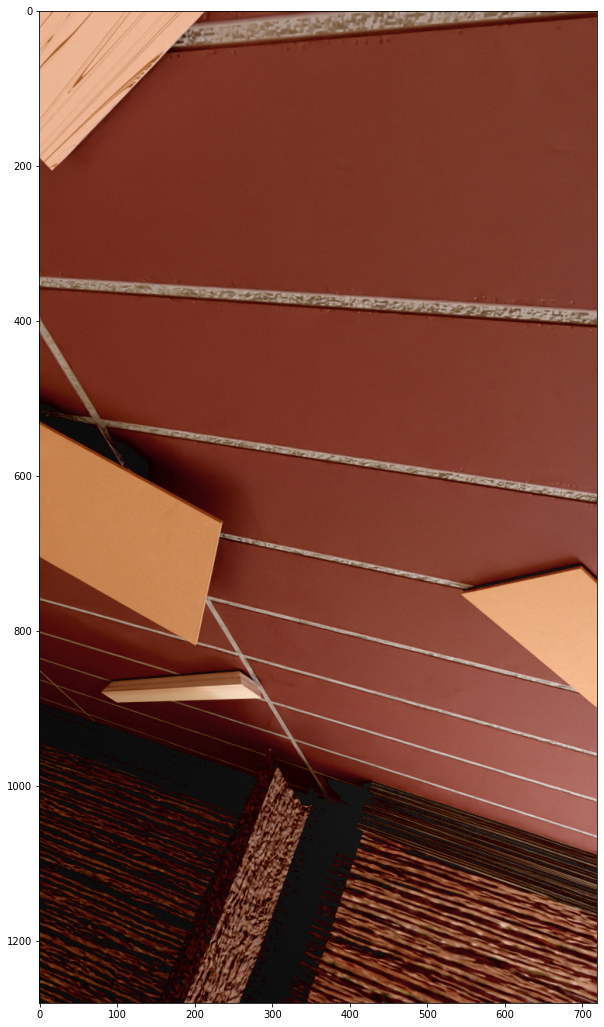

In [8]:
#for image,label in train_ds.take(1):
#        image, mask = image,label
#plt.figure(figsize=(10,20))
#plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0, :, :, :]))


#for image,label in train_ds.take(1):
#    sample_image, sample_mask = image,label
#
#visualize.plot_images(images=sample_image, labels=sample_mask, predictions=None, batch_size=3)

# Model

In [7]:
if weighted_multi_label_sigmoid_edge_loss:
    loss = lambda y_true, y_pred : losses.weighted_multi_label_sigmoid_loss(y_true,y_pred,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
elif focal_loss:
    loss = lambda y_true, y_pred : losses.focal_loss_edges(y_true, y_pred, gamma=gamma, alpha=alpha, weighted_beta=weighted_beta,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
else:
    raise ValueError("either FocalLoss or WeightedMultiLabelSigmoidLoss must be True")
    

In [8]:
if TRAIN_MODEL:
    backbone, output_names = backbones.get_backbone(name=BACKBONE,weights=BACKBONE_WEIGHTS,
                                              height=IMG_SIZE_HEIGHT,width=IMG_SIZE_WIDTH,
                                              alpha=ALPHA, output_layer = BACKBONE_OUTPUT,
                                                            trainable_idx = TRAINABLE_IDX)

    upsample_side_1 = tf.keras.layers.Conv2D(1, kernel_size=1, strides=(1, 1), padding='same')(backbone.output[0])
    upsample_side_2 = features.side_feature_casenet(backbone.output[1],channels=1,kernel_size_transpose=4,stride_transpose=2)
    upsample_side_3 = features.side_feature_casenet(backbone.output[2],channels=1,kernel_size_transpose=8,stride_transpose=4)
    #upsample_side_5 = tf.image.resize(backbone.output[3],(int(IMG_SIZE_HEIGHT/16),int(IMG_SIZE_WIDTH/16)))
    upsample_side_5 = features.side_feature_casenet(backbone.output[3],channels=NUM_CLASSES,kernel_size_transpose=16,stride_transpose=8,name='side5')

    side_outputs = [upsample_side_1,upsample_side_2,upsample_side_3,upsample_side_5]
    concat = features.shared_concatenation(side_outputs,NUM_CLASSES)

    output = features.fused_classification(concat,NUM_CLASSES,name="output")

    model = tf.keras.Model(inputs = backbone.input, outputs = [output,upsample_side_5])

    # tf.keras.utils.plot_model(model,show_shapes = True,to_file = 'h.png')

# Compile and Train Model

In [9]:
if TENSORBOARD:
    %load_ext tensorboard
    %tensorboard --logdir /home/david/SemesterProject/Models/CASENet/logs

In [10]:
if TRAIN_MODEL:
    # learning rate schedule
    base_learning_rate = 0.0005
    end_learning_rate = 0.0001
    decay_step = np.ceil(img_count_train / BATCH_SIZE)*EPOCHS
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(base_learning_rate,decay_steps = decay_step,end_learning_rate = end_learning_rate, power = 0.9)

    frequency = int(np.ceil(img_count_train / BATCH_SIZE)*MODEL_SAVE_EPOCH_FREQ)+1

    logdir = os.path.join(paths['TBLOGS'], datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = paths["CKPT"]+ "/ckpt-loss={val_loss:.2f}-epoch={epoch:.2f}-f1={val_f1:.4f}",
                                                    save_weights_only=False,save_best_only=False,monitor="val_f1",verbose=1,save_freq= 'epoch', period=5),
                tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)]

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=loss,
                  metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                      metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

    history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_real_ds, callbacks=callbacks)

Epoch 1/80


2022-05-23 14:51:50.642854: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


167/167 [==============================] - 98s 538ms/step - loss: 25210.7461 - output_loss: 15795.5889 - side5_loss: 9415.1562 - output_accuracy_edges: 0.8125 - f1: 0.0195 - precision: 0.0101 - recall: 0.3252 - val_loss: 3730.0334 - val_output_loss: 2744.8821 - val_side5_loss: 985.1509 - val_output_accuracy_edges: 0.9499 - val_f1: 0.0578 - val_precision: 0.0310 - val_recall: 0.4266
Epoch 2/80
167/167 [==============================] - 84s 500ms/step - loss: 3857.7722 - output_loss: 2072.9778 - side5_loss: 1784.7933 - output_accuracy_edges: 0.9794 - f1: 0.1953 - precision: 0.1848 - recall: 0.2074 - val_loss: 1849.1267 - val_output_loss: 1277.8519 - val_side5_loss: 571.2748 - val_output_accuracy_edges: 0.9787 - val_f1: 0.1039 - val_precision: 0.0610 - val_recall: 0.3525
Epoch 3/80
167/167 [==============================] - 87s 516ms/step - loss: 3146.4546 - output_loss: 1723.1511 - side5_loss: 1423.3037 - output_accuracy_edges: 0.9820 - f1: 0.2342 - precision: 0.2460 - recall: 0.2237 - v

2022-05-23 14:59:13.160014: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/CASENET_FOCAL_LOSS_0.6_g2_a2_random/CKPT/ckpt-loss=1426.17-epoch=5.00-f1=0.1253/assets
167/167 [==============================] - 100s 598ms/step - loss: 2552.0183 - output_loss: 1361.5951 - side5_loss: 1190.4219 - output_accuracy_edges: 0.9834 - f1: 0.2912 - precision: 0.3076 - recall: 0.2770 - val_loss: 1426.1740 - val_output_loss: 852.4445 - val_side5_loss: 573.7292 - val_output_accuracy_edges: 0.9865 - val_f1: 0.1253 - val_precision: 0.0807 - val_recall: 0.2798
Epoch 6/80
167/167 [==============================] - 89s 528ms/step - loss: 2432.6252 - output_loss: 1291.2700 - side5_loss: 1141.3544 - output_accuracy_edges: 0.9837 - f1: 0.2866 - precision: 0.3145 - recall: 0.2636 - val_loss: 2111.9065 - val_output_loss: 1184.1935 - val_side5_loss: 927.7131 - val_output_accuracy_edges: 0.9781 - val_f1: 0.0697 - val_precision: 0.0412 - val_recall: 0.2260
Epoch 7/80
167/167 [==============

Epoch 38/80
167/167 [==============================] - 90s 537ms/step - loss: 1250.1642 - output_loss: 557.4856 - side5_loss: 692.6783 - output_accuracy_edges: 0.9902 - f1: 0.5942 - precision: 0.6302 - recall: 0.5624 - val_loss: 825.2437 - val_output_loss: 459.6548 - val_side5_loss: 365.5888 - val_output_accuracy_edges: 0.9922 - val_f1: 0.2678 - val_precision: 0.2019 - val_recall: 0.3977
Epoch 39/80
167/167 [==============================] - 93s 555ms/step - loss: 1168.2158 - output_loss: 519.0496 - side5_loss: 649.1671 - output_accuracy_edges: 0.9907 - f1: 0.6475 - precision: 0.6571 - recall: 0.6385 - val_loss: 1233.3257 - val_output_loss: 620.9426 - val_side5_loss: 612.3831 - val_output_accuracy_edges: 0.9908 - val_f1: 0.1845 - val_precision: 0.1335 - val_recall: 0.2983
Epoch 40/80
167/167 [==============================] - ETA: 0s - loss: 1174.8530 - output_loss: 518.1928 - side5_loss: 656.6604 - output_accuracy_edges: 0.9907 - f1: 0.6380 - precision: 0.6523 - recall: 0.6245
Epoch 4

Epoch 55/80
167/167 [==============================] - ETA: 0s - loss: 1131.9828 - output_loss: 485.8921 - side5_loss: 646.0911 - output_accuracy_edges: 0.9914 - f1: 0.6641 - precision: 0.6767 - recall: 0.6525
Epoch 55: saving model to /home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/CASENET_FOCAL_LOSS_0.6_g2_a2_random/CKPT/ckpt-loss=906.77-epoch=55.00-f1=0.2224
INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/CASENET_FOCAL_LOSS_0.6_g2_a2_random/CKPT/ckpt-loss=906.77-epoch=55.00-f1=0.2224/assets
167/167 [==============================] - 103s 617ms/step - loss: 1131.9828 - output_loss: 485.8921 - side5_loss: 646.0911 - output_accuracy_edges: 0.9914 - f1: 0.6642 - precision: 0.6767 - recall: 0.6526 - val_loss: 906.7665 - val_output_loss: 489.8549 - val_side5_loss: 416.9117 - val_output_accuracy_edges: 0.9903 - val_f1: 0.2224 - val_precision: 0.1578 - val_recall: 0.3769
Epoch 56/80
167/167 [===========================

Epoch 71/80
167/167 [==============================] - 89s 529ms/step - loss: 918.3030 - output_loss: 387.9602 - side5_loss: 530.3431 - output_accuracy_edges: 0.9926 - f1: 0.7370 - precision: 0.7141 - recall: 0.7615 - val_loss: 777.3164 - val_output_loss: 411.8139 - val_side5_loss: 365.5025 - val_output_accuracy_edges: 0.9925 - val_f1: 0.3071 - val_precision: 0.2315 - val_recall: 0.4560
Epoch 72/80
167/167 [==============================] - 89s 531ms/step - loss: 910.9104 - output_loss: 385.4059 - side5_loss: 525.5045 - output_accuracy_edges: 0.9927 - f1: 0.7287 - precision: 0.7154 - recall: 0.7432 - val_loss: 697.8103 - val_output_loss: 380.6385 - val_side5_loss: 317.1717 - val_output_accuracy_edges: 0.9936 - val_f1: 0.3414 - val_precision: 0.2693 - val_recall: 0.4661
Epoch 73/80
167/167 [==============================] - 85s 505ms/step - loss: 896.2214 - output_loss: 379.7008 - side5_loss: 516.5204 - output_accuracy_edges: 0.9927 - f1: 0.7378 - precision: 0.7107 - recall: 0.7671 - va

In [16]:
model_ckpt = os.listdir(paths['CKPT'])

f1_max = 0
for ckpt_name in model_ckpt:
    if float(ckpt_name[-4:]) > f1_max:
        f1_max = float(ckpt_name[-4:])
        model_path = paths['CKPT']+"/"+ckpt_name
        
        print(model_path)

custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                  "F1Edges": metrics.F1Edges,
                  "<lambda>":loss}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/CASENET_FOCAL_LOSS_0.6_g2_a2_random/CKPT/ckpt-loss=906.77-epoch=55.00-f1=0.2224
/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/CASENET_FOCAL_LOSS_0.6_g2_a2_random/CKPT/ckpt-loss=759.04-epoch=45.00-f1=0.2846
/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/CASENET_FOCAL_LOSS_0.6_g2_a2_random/CKPT/ckpt-loss=696.79-epoch=75.00-f1=0.3149
/home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/CASENET_FOCAL_LOSS_0.6_g2_a2_random/CKPT/ckpt-loss=655.07-epoch=65.00-f1=0.3404


# Plot Results

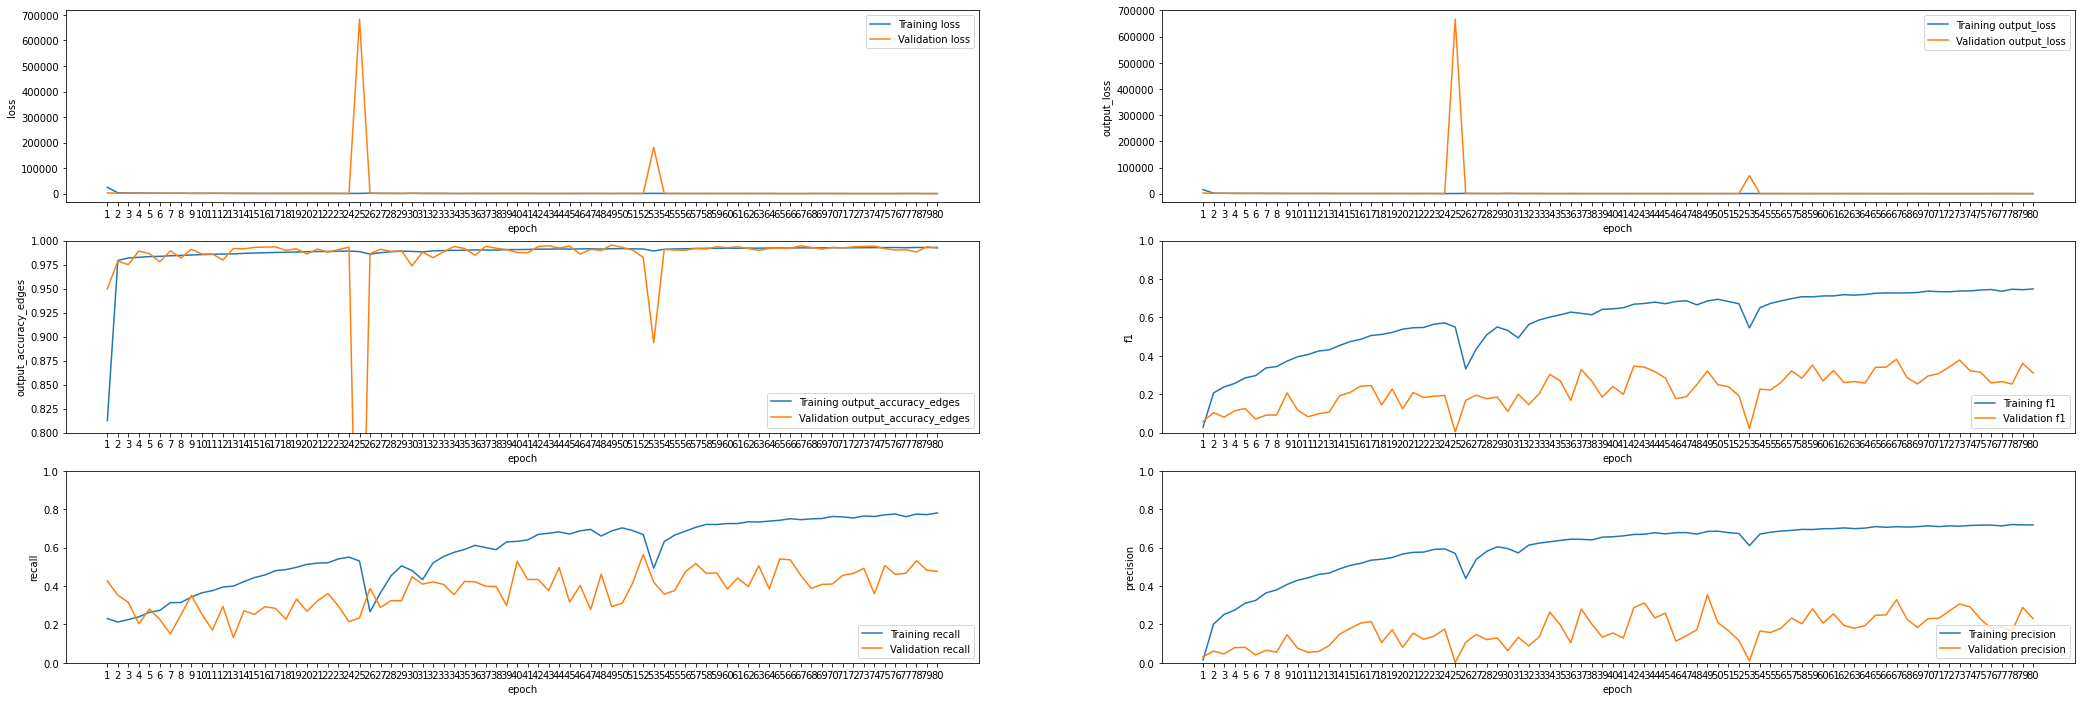

In [17]:
if TRAIN_MODEL:
    plot_losses = ["loss", "output_loss"]
    plot_metrics = ["output_accuracy_edges", "f1", "recall", "precision"]

    path = os.path.join(paths["FIGURES"],"training.svg")

    visualize.plot_training_results(res=history.history, losses=plot_losses, metrics=plot_metrics, save=SAVE, path=path)

4/4 - 2s - loss: 0.0000e+00 - output_accuracy_edges: 0.7339 - f1: 0.0189 - precision: 0.0096 - recall: 0.9985 - 2s/epoch - 483ms/step
4/4 - 3s - loss: 0.0000e+00 - output_accuracy_edges: 0.9416 - f1: 0.0877 - precision: 0.0459 - recall: 0.9595 - 3s/epoch - 666ms/step
4/4 - 2s - loss: 0.0000e+00 - output_accuracy_edges: 0.9699 - f1: 0.1648 - precision: 0.0909 - recall: 0.8816 - 2s/epoch - 490ms/step
4/4 - 2s - loss: 0.0000e+00 - output_accuracy_edges: 0.9811 - f1: 0.2299 - precision: 0.1345 - recall: 0.7895 - 2s/epoch - 493ms/step
4/4 - 2s - loss: 0.0000e+00 - output_accuracy_edges: 0.9879 - f1: 0.2905 - precision: 0.1847 - recall: 0.6804 - 2s/epoch - 493ms/step
4/4 - 2s - loss: 0.0000e+00 - output_accuracy_edges: 0.9903 - f1: 0.3185 - precision: 0.2146 - recall: 0.6168 - 2s/epoch - 478ms/step
4/4 - 2s - loss: 0.0000e+00 - output_accuracy_edges: 0.9922 - f1: 0.3404 - precision: 0.2482 - recall: 0.5415 - 2s/epoch - 485ms/step
4/4 - 2s - loss: 0.0000e+00 - output_accuracy_edges: 0.9937 - 

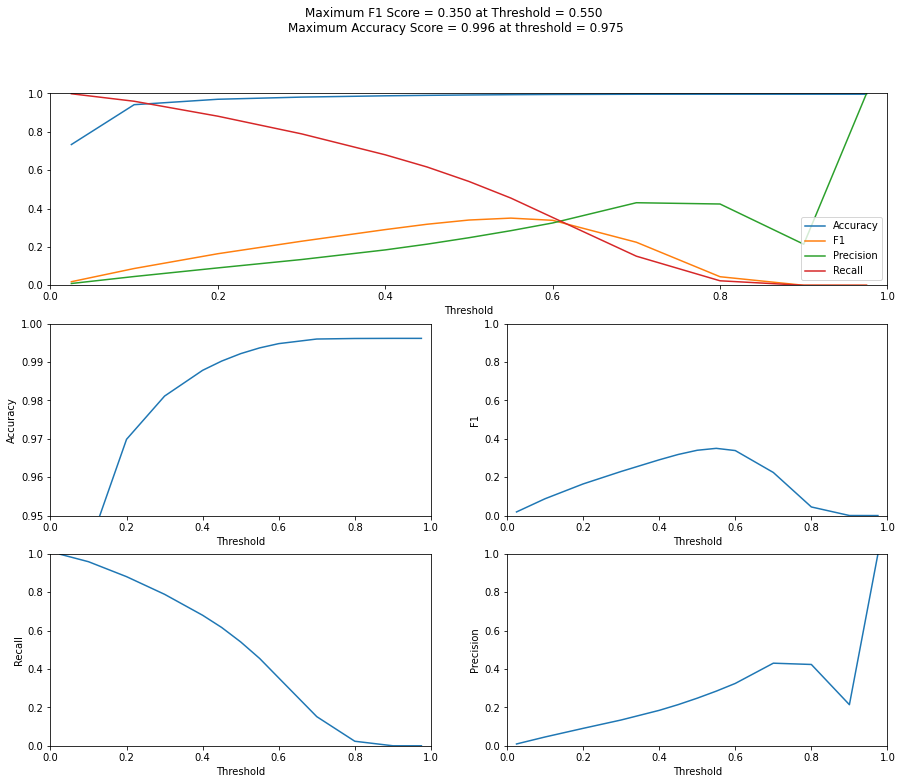

In [18]:
### Maximum F1 Score:
if not TRAIN_MODEL:
    step_width = 0.05
    threshold_range = [0.05,0.95]
    threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)
    threshold_array = np.array([0.025, 0.1, 0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8, 0.9, 0.975])

    path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation_test_ds.svg")
    threshold_f1_max = visualize.plot_threshold_metrics_evaluation_class(model=model, 
                                                                         ds=test_ds,
                                                                         num_classes=NUM_CLASSES,
                                                                         threshold_array=threshold_array, 
                                                                         threshold_edge_width=0, save=SAVE, 
                                                                         path=path_metrics_evaluation_plot)

2022-05-23 17:16:40.955380: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: slice index 1 of dimension 0 out of bounds.


InvalidArgumentError: slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

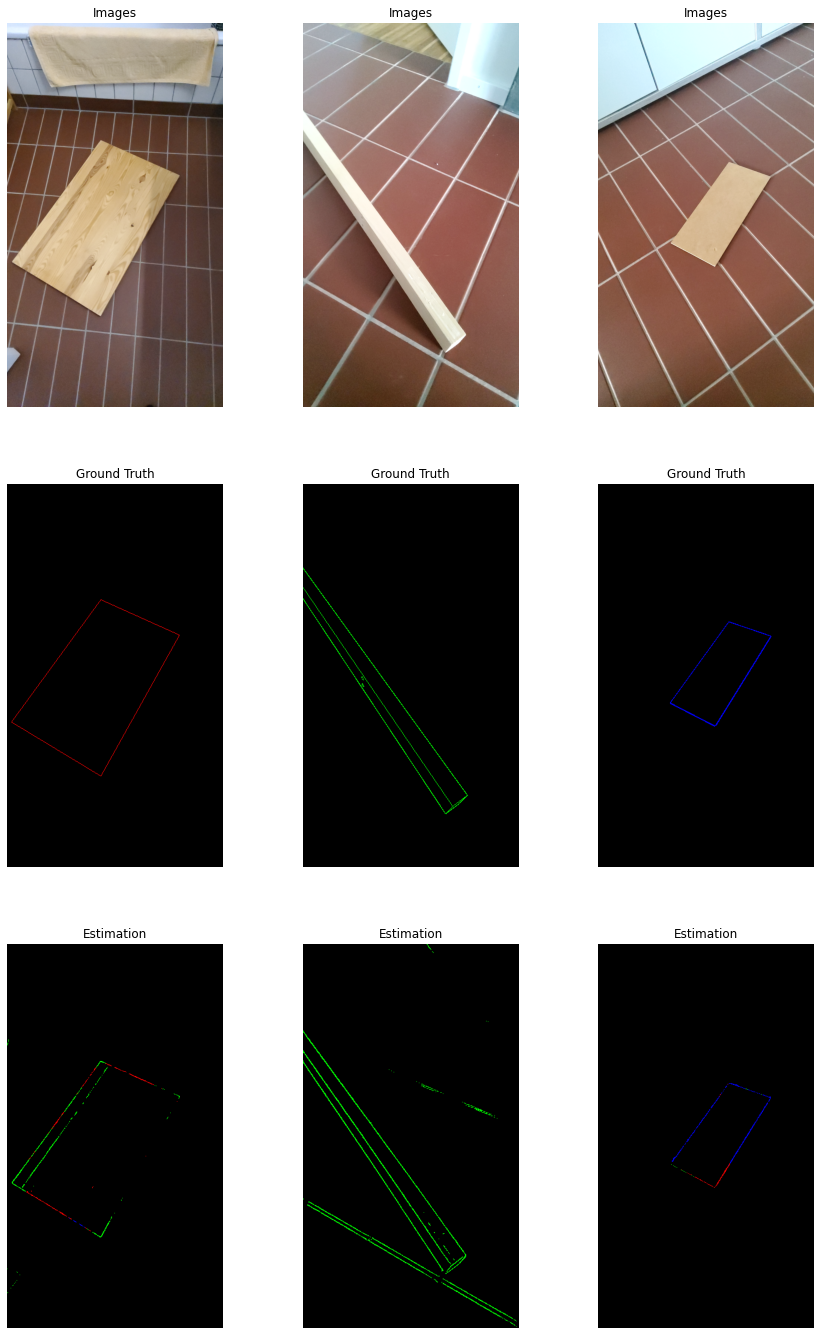

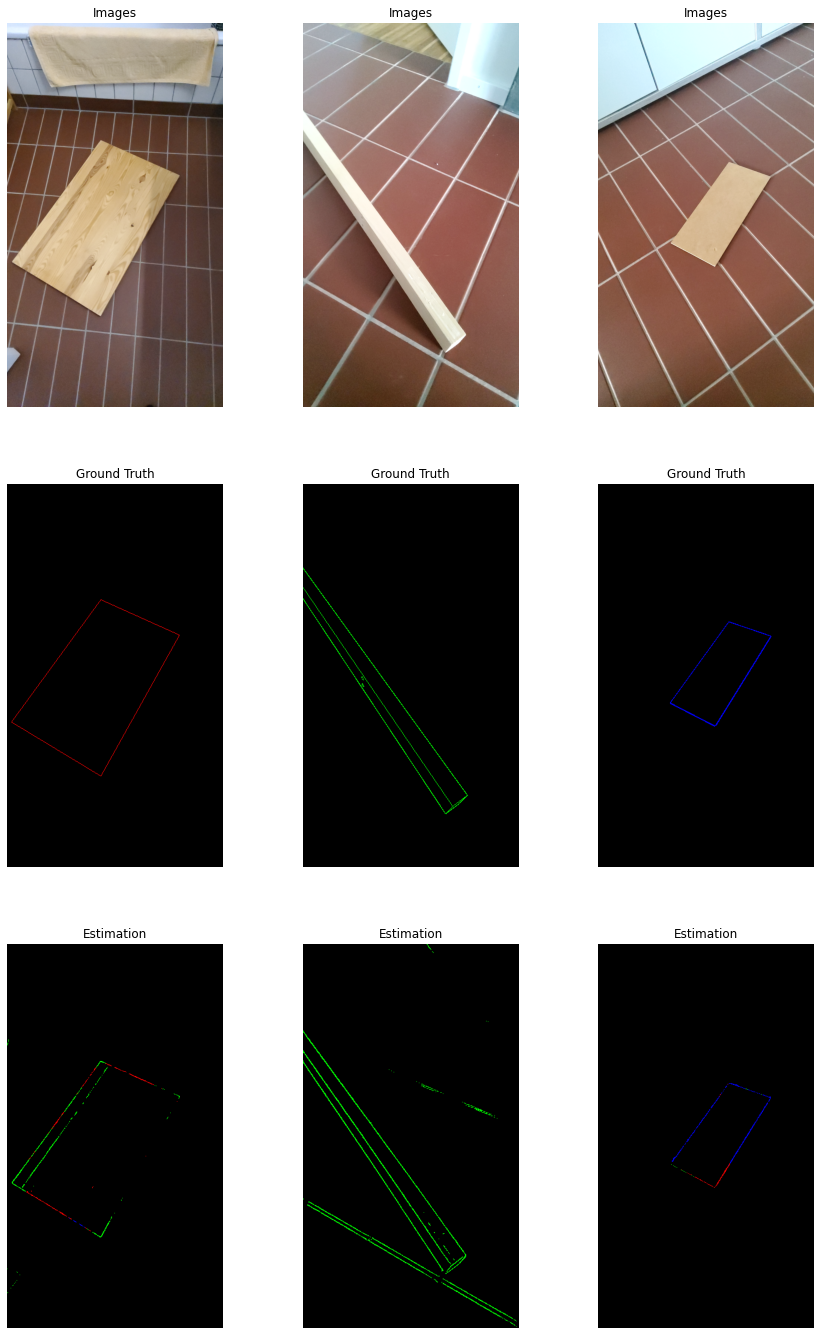

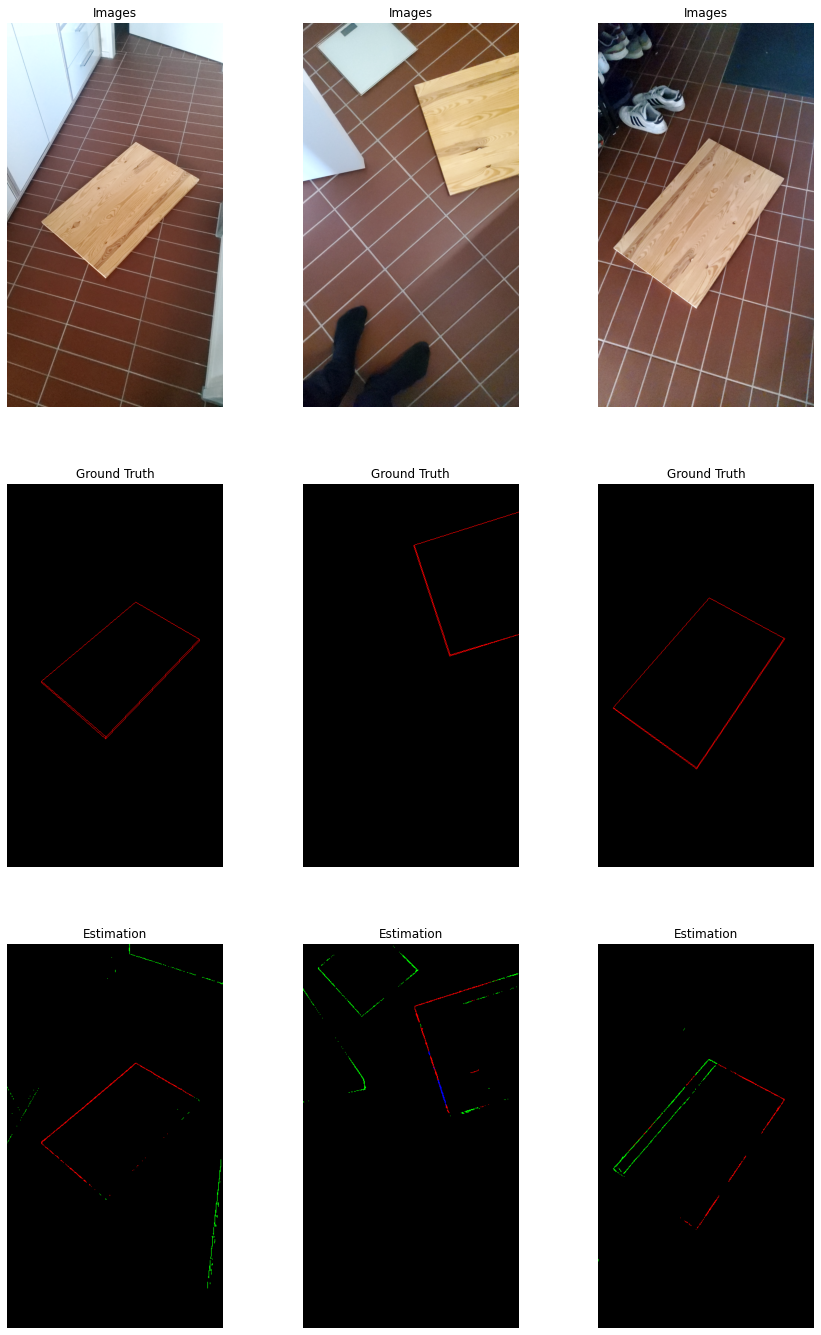

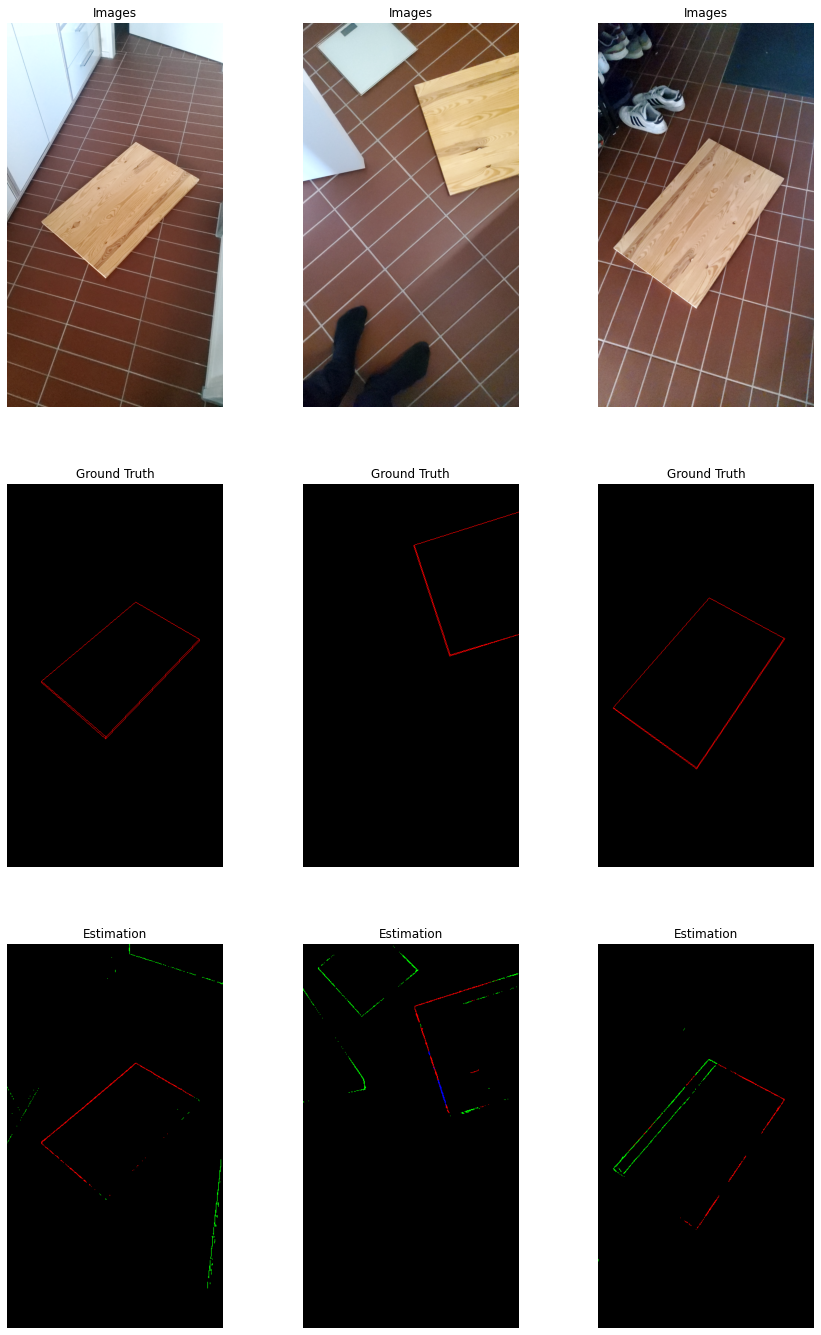

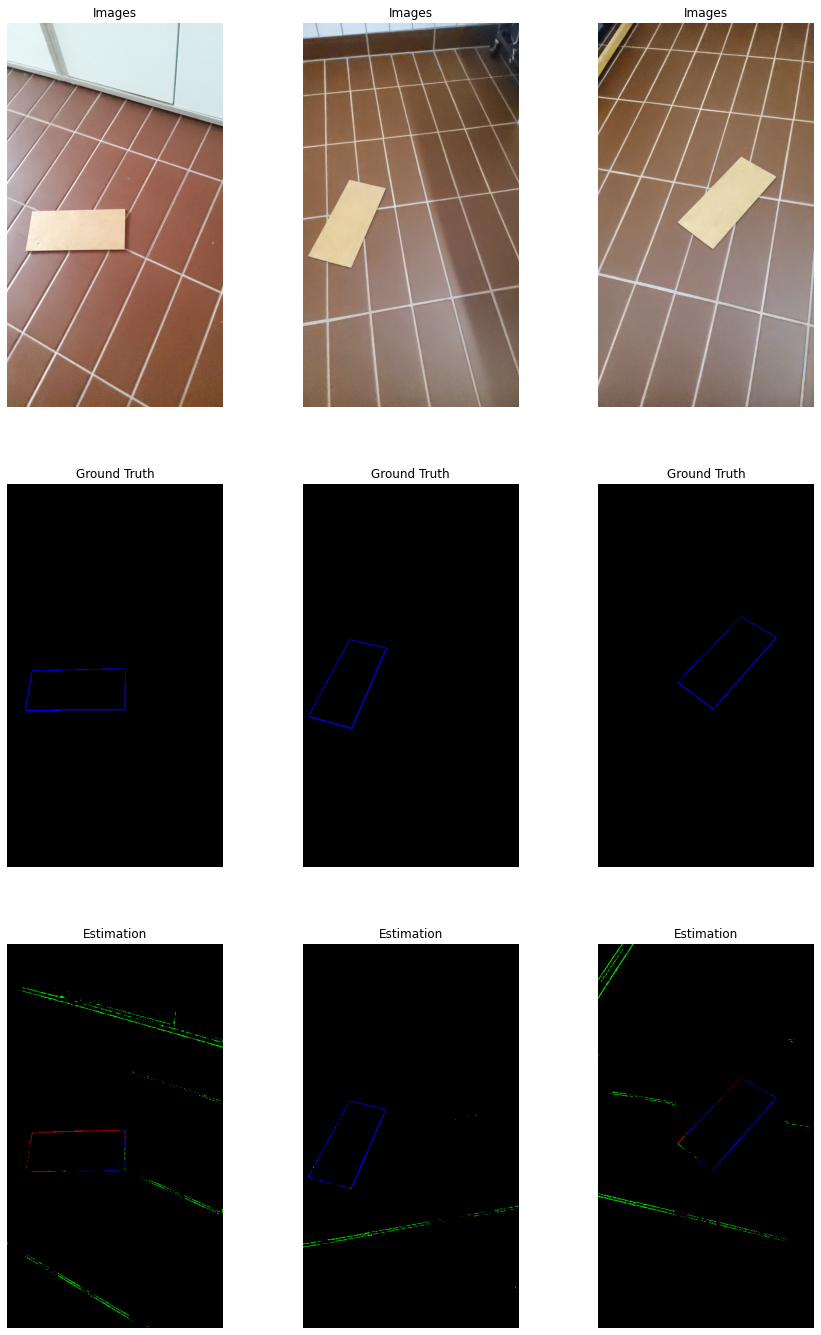

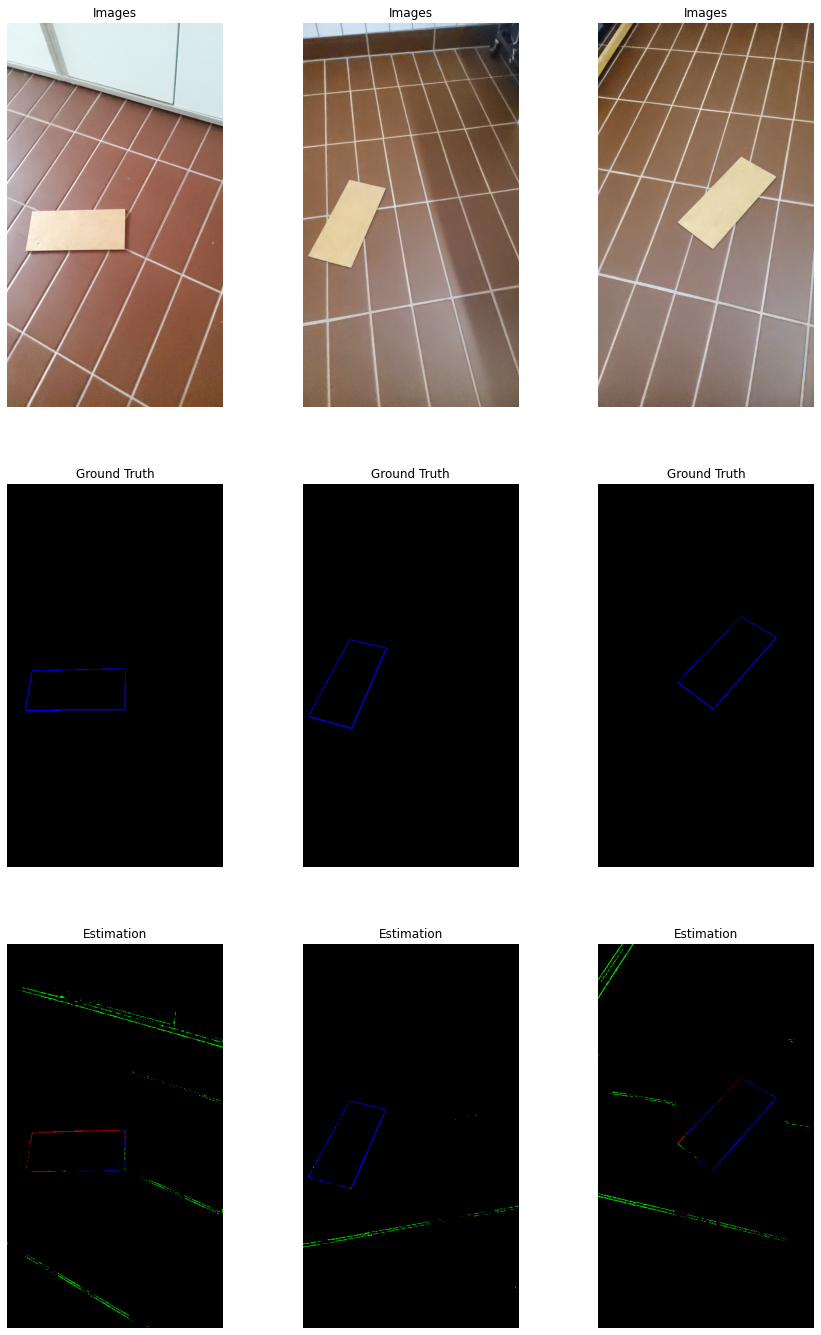

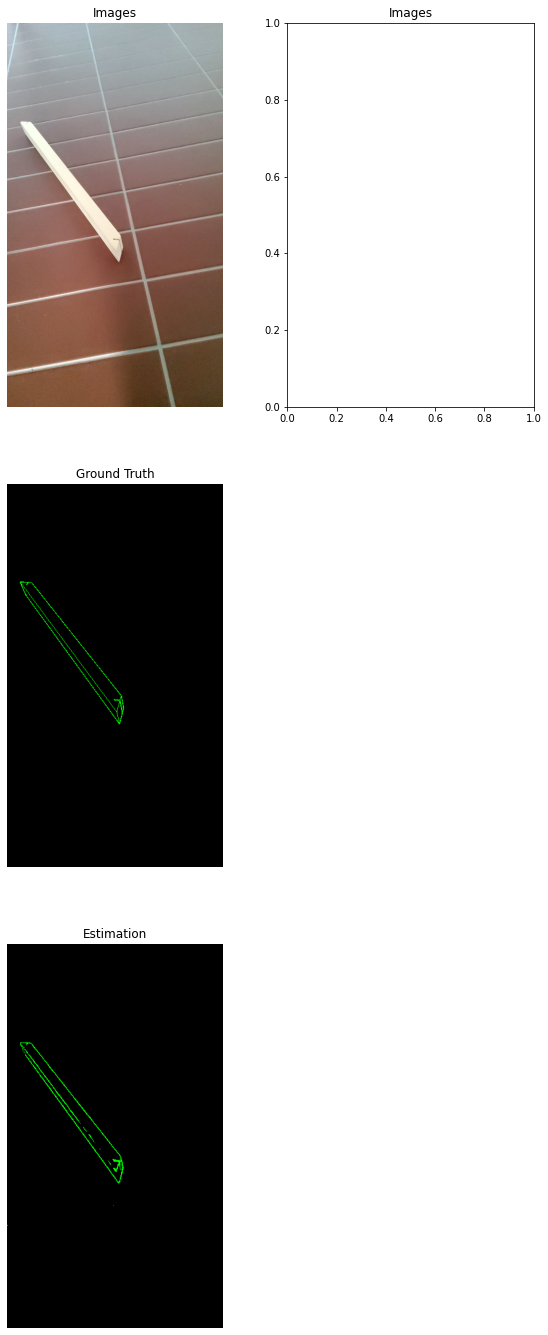

In [19]:
if not TRAIN_MODEL:
    i = 0
    for img, label in test_ds.take(4):
        img, label = img, label

        threshold = 0.5

        predictions = model.predict(img)
        predictions = tools.predict_class_postprocessing(predictions[0], threshold=threshold)

        path = os.path.join(paths["FIGURES"],"img_test_threshold_{}_{}".format(threshold,i))
        visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=3)

        threshold = threshold_f1_max
        path = os.path.join(paths["FIGURES"],"img_test_ods_{}".format(i))
        visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=3)

        i += 1

# Fine Tuning

In [ ]:
if FINE_TUNING and TRAIN_MODEL:

    # Fine-tune from this layer onwards
    fine_tune_output = output_names[1-1]

    model.trainable = True

    # Freeze all the layers before the `fine_tune_at` layer: 
    for submodel in model.layers:
        if submodel.name == "base_model":
            for layer in submodel.layers:
                layer.trainable = False
                if layer.name == fine_tune_output:
                    break
    
    
    total_epochs =  EPOCHS + FINE_TUNE_EPOCHS

    base_learning_rate = 0.00001
    end_learning_rate =  0.00001
    decay_step = np.floor(img_count_train / BATCH_SIZE)*FINE_TUNE_EPOCHS
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        base_learning_rate,decay_steps = decay_step,end_learning_rate = end_learning_rate, power = 0.9)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=loss,
                  metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                      metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})
    

    history_fine = model.fit(train_ds, epochs=total_epochs, 
                               initial_epoch=history.epoch[-1]+1,validation_data=train_ds.take(1), 
                               callbacks=callbacks)
    
    plot_losses = ["loss", "output_loss"]
    plot_metrics = ["output_accuracy_edges", "f1", "recall", "precision"]
    
    path = os.path.join(paths["FIGURES"],"fine_tuning_training.svg")
    
    visualize.plot_training_results(res=history.history, res_fine = history_fine.history, 
                                losses=plot_losses, metrics=plot_metrics, save=SAVE, path=path, epochs=EPOCHS)
    
    path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation__fine_tune_test_ds.svg")
    visualize.plot_threshold_metrics_evaluation(model=model, ds=test_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=0, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.9)
        
    for img, label in test_ds.take(1):
        img, label = img, label

    predictions = model.predict(img)    
    predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

    path = os.path.join(paths["FIGURES"],"fine_tuning_images_0,5")
    visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=3)

# Evaluate on Test DS of Real Images

In [ ]:
DATA_REAL = 'RealRed'
TRAIN_REAL = 'Train'
TEST_REAL = 'Test'
TEST_HARD_REAL = 'Test Hard'
IMG_ONLY_REAL = 'Img Only'
BS_REAL = 8

paths_real, files_real = data_processing.path_definitions(HALF, MODEL, DATA_REAL, TRAIN_REAL, TEST_REAL, TEST_HARD_REAL, IMG_ONLY_REAL, make_dirs=False)

test_real_ds, img_count_test_real = data_processing.load_dataset(paths_real,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_real_ds = data_processing.dataset_processing(test_real_ds, cache=False, shuffle=False, batch_size=BS_REAL, prefetch=False, img_count = img_count_test_real)

## Metrics Evaluation

In [ ]:
if not TRAIN_MODEL:
    step_width = 0.025
    threshold_range = [0.025, 0.975]
    threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)

    path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation_test_real_edge_threshold_{:.1f}.svg".format(0))
    threshold_f1_max = visualize.plot_threshold_metrics_evaluation_class(model=model, ds=test_real_ds, 
                                                                   num_classes = NUM_CLASSES,
                                                                   threshold_array=threshold_array, 
                                                                   threshold_edge_width=0, save=SAVE, 
                                                                   path=path_metrics_evaluation_plot)

## Visual Results

In [ ]:
if not TRAIN_MODEL:
    for img, label in test_real_ds.take(1):
        img, label = img, label


    threshold = 0.5

    predictions = model.predict(img)    
    predictions = tools.predict_class_postprocessing(predictions[0], threshold=threshold)

    path = os.path.join(paths["FIGURES"],"images_test_real_threshold_{:.2f}".format(threshold))
    visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=8)

    threshold = threshold_f1_max

    predictions = model.predict(img)    
    predictions = tools.predict_class_postprocessing(predictions[0], threshold=threshold)

    path = os.path.join(paths["FIGURES"],"images_test_real_threshold_ods")
    visualize.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=8)

# Save Model

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=loss,
                  metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                      metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

if SAVE:
    model.save(paths["MODEL"])
    
    custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                      "F1Edges": metrics.F1Edges,
                      "<lambda>":loss}
    
    model = tf.keras.models.load_model(paths["MODEL"], custom_objects=custom_objects)

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/CASENET_FOCAL_LOSS_0.6_g2_a2_random/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/SceneNetFloorTiledTextureRandom/CASENET_FOCAL_LOSS_0.6_g2_a2_random/assets


# Plot Other, Additional Data.

# Addtional Elements to Consider in other Projects

* Data augmentation for small datasets